### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

tf.config.run_functions_eagerly(True)

### Utilities

In [2]:
def plot_multiple_images(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
        
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(image, cmap='binary')
        plt.axis('off')

### Download and Prepare the Dataset

We will first load the MNIST dataset. For this project, we will just be using the training images so you might notice that we are not getting the test split nor the training labels below. You will also preprocess these by normalizing the pixel values.

In [3]:
(x_train, _), _ = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype(np.float32) / 255

In [4]:
BATCH_SIZE = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

## Build the Model

We will now create the two main parts of the GAN: 
* generator - creates the fake data
* discriminator - determines if an image is fake or real

We will stack Dense layers using the Sequential API to build these sub networks.

### Generator

The generator takes in random noise and uses it to create fake images. For that, this model will take in the shape of the random noise and will output an image with the same dimensions of the MNIST dataset (i.e. 28 x 28). 

[SELU](https://arxiv.org/abs/1706.02515) is found to be a good activation function for GANs and we use that in the first two dense networks. The final dense networks is activated with a sigmoid because we want to generate pixel values between 0 and 1. This is then reshaped to the dimensions of the MNIST dataset.

In [5]:
random_normal_dimension = 32

generator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[random_normal_dimension]),
    tf.keras.layers.Dense(64, activation='selu'),
    tf.keras.layers.Dense(128, activation='selu'),
    tf.keras.layers.Dense(28 * 28, activation='sigmoid'),
    tf.keras.layers.Reshape([28, 28])
])

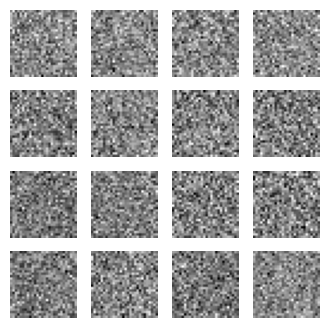

In [6]:
test_noise = tf.random.normal([16, random_normal_dimension])

test_image = generator(test_noise)

plot_multiple_images(test_image, n_cols=4)

### Discriminator

The discriminator takes in the input (fake or real) images and determines if it is fake or not. Thus, the input shape will be that of the training images. This will be flattened so it can be fed to the dense networks and the final output is a value between 0 (fake) and 1 (real).

Like the generator, we use SELU activation in the first two dense networks and we activate the final network with a sigmoid.

In [7]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='selu'),
    tf.keras.layers.Dense(units=64, activation='selu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

## Configure Training Parameters

You will now prepare the models for training. We can measure the loss with `binary_crossentropy` because you're expecting labels to be either 0 (fake) or 1 (real).

In [8]:
gan = tf.keras.models.Sequential([generator, discriminator])

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Train the Model

Next, we will define the training loop. This consists of two phases:

* Phase 1 - trains the discriminator to distinguish between fake or real data
* Phase 2 - trains the generator to generate images that will trick the discriminator

At each epoch, you will display a sample gallery of images to see the fake images being created by the generator.

In [10]:
def train_gan(gan, dataset, random_normal_dimension, n_epochs=50):
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))
        
        for real_images in dataset:
            
            batch_size = real_images.shape[0]
            
            # Train the discriminator - PHASE 1
            noise = tf.random.normal(shape=[batch_size, random_normal_dimension])
            
            fake_images = generator(noise)
            
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            discriminator.trainable = True
            
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            noise = tf.random.normal(shape=[batch_size, random_normal_dimension])
            
            generator_labels = tf.constant([[1.]] * batch_size)
            
            discriminator.trainable = False
            
            gan.train_on_batch(noise, generator_labels)
            
        plot_multiple_images(fake_images, 8)
        plt.show()

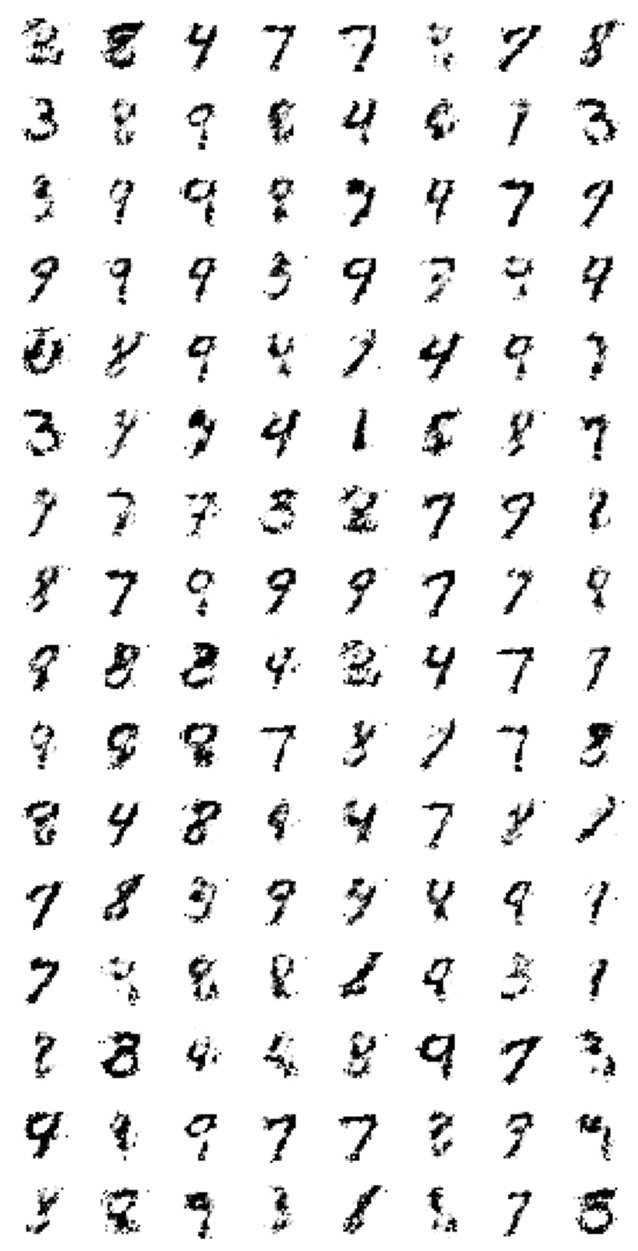

In [11]:
train_gan(gan, dataset, random_normal_dimension, n_epochs=20)